# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import zfit
from zfit import z

2022-05-09 20:22:38.373036: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-05-09 20:22:38.373145: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-09 20:22:45.115158: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-09 20:22:45.115248: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-09 20:22:45.115293: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-KJ9UEOTB): /proc/driver/nvidia/version does not exist
2022-05-09 20:22:45.115778: I tensorflow/core/platform/cpu_fe

# Plotting function

In [2]:
size_normal = 10000

def plot_model(model, data, scale=1, plot_data=True):  # we will use scale later on

    nbins = 50

    lower, upper = data.data_range.limit1d
    x = tf.linspace(lower, upper, num=1000)  # np.linspace also works
    y = model.pdf(x) * size_normal / nbins * data.data_range.area()
    y *= scale
    plt.plot(x, y)
    data_plot = zfit.run(z.unstack_x(data))  # we could also use the `to_pandas` method
    if plot_data:
        plt.hist(data_plot, bins=nbins)

# Different models

In [3]:
# Prints all the available models for this version of zfit

print(zfit.pdf.__all__)

['BasePDF', 'BaseFunctor', 'Exponential', 'CrystalBall', 'DoubleCB', 'Gauss', 'Uniform', 'TruncatedGauss', 'WrapDistribution', 'Cauchy', 'Poisson', 'Chebyshev', 'Legendre', 'Chebyshev2', 'Hermite', 'Laguerre', 'RecursivePolynomial', 'ProductPDF', 'SumPDF', 'GaussianKDE1DimV1', 'FFTConvPDFV1', 'ZPDF', 'SimplePDF', 'SimpleFunctorPDF']


To create more realistic models, we can create fits with the sum of other models:
- Signal component: CrystalBall
- Combinatorial background: Exponential
- Partial reconstructed background on the left: Kernel Density Estimation

The KDE in the docs is not available in this version in zfit, so we use a previous funcion available in zfit=0.5.2

In [4]:
# Creating the observable

mass_obs = zfit.Space('mass', (0, 1000))

In [5]:
# Creating the parameters for the CristallBall signal component

# Signal component

mu_sig = zfit.Parameter('mu_sig', 400, 100, 600)
sigma_sig = zfit.Parameter('sigma_sig', 50, 1, 100)
alpha_sig = zfit.Parameter('alpha_sig', 200, 100, 400, floating=False)  # won't be used in the fit
n_sig = zfit.Parameter('n sig', 4, 0.1, 30, floating=False)
signal = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_sig, sigma=sigma_sig, alpha=alpha_sig, n=n_sig)

In [6]:
# paramters for the combinatorial background model component

lam = zfit.Parameter('lambda', -0.01, -0.05, -0.001)
comb_bkg = zfit.pdf.Exponential(lam, obs=mass_obs)

In [7]:
# Creating the separated models

part_reco_data = np.random.normal(loc=200, scale=150, size=700)
part_reco_data = zfit.Data.from_numpy(obs=mass_obs, array=part_reco_data)  
# we don't need to do this but now we're sure it's inside the limits

part_reco = zfit.pdf.GaussianKDE1DimV1(obs=mass_obs, data=part_reco_data, bandwidth='adaptive')
# The parameter bandwidth='adaptive_zfit', 
# doesn't work with this version of zfit, we should use
# 'adaptive' or 'adaptiveV1'

# Composing models

Here we manage 1D models. The extension to multiple dimensions will be dealed with in the "custom models tutorial".

`SumPDF`: takes pdfs and fractions.

With fractions we have the cases:
- *n-1* fracitons_ The nth fraction will be 1-sum(fracs)
- *n* fracs: No normalization is done by SumPDF. fracs have to be implicitly normalized, else there can be bad fitting behavior (1 extra degree of freedom).

In [8]:
# Define the parameters
sig_frac = zfit.Parameter('sig_frac', 0.3, 0, 1)
comb_bkg_frac = zfit.Parameter('comb_bkg_frac', 0.25, 0, 1)

# Create a model that is a sum of three models
model = zfit.pdf.SumPDF([signal, comb_bkg, part_reco], [sig_frac, comb_bkg_frac])

# We gave here two entries in the array of yields, if all pdfs are extended,
# there is no need for a yield

To create a data sample: We want to fit this dataset later, we will create it with slightly different values of `sig_frac`, so we set it temporarily with

In [9]:
print(f"before: {sig_frac}")
with sig_frac.set_value(0.25):
    print(f"new value: {sig_frac}")
print(f"after 'with': {sig_frac}")

before: <zfit.Parameter 'sig_frac' floating=True value=0.3>
new value: <zfit.Parameter 'sig_frac' floating=True value=0.25>
after 'with': <zfit.Parameter 'sig_frac' floating=True value=0.3>


The latter doesn't scale up, so we should use `zfit.param.set_values` helper function to set values of parameters

In [10]:
with zfit.param.set_values([mu_sig, sigma_sig, sig_frac, comb_bkg_frac, lam], [370, 34, 0.18, 0.15, -0.006]):
    data = model.sample(n=10000)

/tmp/ipykernel_184/1490018972.py:7: UserWarning: The function <function Space.limit1d at 0x7f252a1421f0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('mass',), axes=(0,), limits=(array([[0.]]), array([[1000.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  lower, upper = data.data_range.limit1d
/tmp/ipykernel_184/1490018972.py:9: UserWarning: The function <function Space.area at 0x7f252a13ef70> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('mass',), axes=(0,), limits=(array([[0.]]), array([[1000.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  y = model.pdf(x) * size_normal / nbins * data.data_range.area()


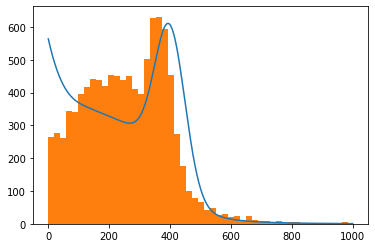

In [11]:
#Plotting the still not fitted model and data

plot_model(model, data);

Plotting the different components of the PDF can be done
- separately
- generalized accessing the `pdfs` atrbute

In [12]:
# Define the composed model with the pdfs defined in odel.pdfs
# which has the pdfs that make up the model

def plot_comp_model(model, data):
    for mod, frac in zip(model.pdfs, model.params.values()):
        plot_model(mod, data, scale=frac, plot_data=False)
    plot_model(model, data)

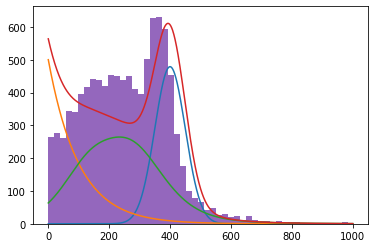

In [13]:
plot_comp_model(model, data)

In [14]:
print(model.params)

OrderedDict([('frac_0', <zfit.Parameter 'sig_frac' floating=True value=0.3>), ('frac_1', <zfit.Parameter 'comb_bkg_frac' floating=True value=0.25>), ('frac_2', <zfit.ComposedParameter 'Composed_autoparam_2' params=OrderedDict([('param_0', <zfit.Parameter 'sig_frac' floating=True value=0.3>), ('param_1', <zfit.Parameter 'comb_bkg_frac' floating=True value=0.25>)]) value=0.45>)])


## Extended PDFs

The PDFs we have seen have information about the shape but not the absolute scale. We extend a PDF by adding a yield to it:

`model.is_extended = True`

- `get_yield`: Returns the yield parameter
- `ext_{pdf,integrate}`: return the pdf or integral of the model multiplied by the yield
- `sample`: Does nos require the argument *n*. It gets *n* by a poissonian sampled *n*.

What is yield?

`SumPDF` does not strictly need `fracs` anymore: if all input PDFs are extended, the sum will be as well and use the (normalized) yields as fracs

The preferred way to create an extended PDF is to use `PDF.create_extendted(yield)`. However, since this relies on copying the PDF, there is also a `set_yield(yield)` method that sets the yield in place.

In [15]:
# Method 1: Creating a copy of the model that is based on the previous one

yield_model = zfit.Parameter('yield_model', 10000, 0, 20000, step_size=10)
model_ext = model.create_extended(yield_model)

we can create the models as extended and sum them

In [16]:
#Parameter yield 1
sig_yield = zfit.Parameter('sig_yield', 2000, 0, 10000, step_size=1)

#Method 1: Creating a extended pdf based on signal
sig_ext = signal.create_extended(sig_yield)

#Parameter yield 2
comb_bkg_yield = zfit.Parameter('comb_bkg_yield', 6000, 0, 10000, step_size=1)

#Method 1: The background model can create an extended yield also
comb_bkg_ext = comb_bkg.create_extended(comb_bkg_yield)

#The GaussianKDE1DimV1 does not have a parameter or yield
part_reco_yield = zfit.Parameter('part_reco_yield', 2000, 0, 10000, step_size=1)

# Method 2: Setting the current pdf to a extended form using the part_reco_yield
part_reco.set_yield(part_reco_yield)  # unfortunately, `create_extended` does not work here. But no problem, it won't change anyting.

# Creating a new pdf that is extended, this time is the same as the original,
# since we modified it

part_reco_ext = part_reco

In [43]:
#Creaging the sum of extended models

model_ext_sum = zfit.pdf.SumPDF([sig_ext, comb_bkg_ext, part_reco_ext])

# Loss

Combines the model and the data to build things like a *Likelihood* (Like the NLL).

It can contain *constraints*.

If the data takes weights, these are automatically taken into account.

In [17]:
# Creating observable for Gaussian model

obs = zfit.Space('obs1', (-5, 10))

In [18]:
# Creating params for the Gaussian

mu = zfit.Parameter('mu', 1, -3, 3, step_size=0.2)
sigma_num = zfit.Parameter('sigma42', 1, 0.1, 10, floating=False)

In [30]:
print(f"sigma is float: {sigma_num.floating}")
sigma_num.floating = True
print(f"sigma is float: {sigma_num.floating}")

sigma is float: False
sigma is float: True


In [31]:
# Creating the gaussian model

gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma_num)

In [32]:
gauss.params

OrderedDict([('mu', <zfit.Parameter 'mu' floating=True value=1>),
             ('sigma', <zfit.Parameter 'sigma42' floating=True value=1>)])

In [33]:
# Why do we have here just mu, and not sigma?

gauss.get_params()

OrderedSet([<zfit.Parameter 'mu' floating=True value=1>, <zfit.Parameter 'sigma42' floating=True value=1>])

In [34]:
# Creating normal data from the pdf

data_normal = gauss.create_sampler(n=size_normal, limits=(-5, 10))

In [35]:
nll_gauss = zfit.loss.UnbinnedNLL(gauss, data_normal)

In [36]:
data_normal.resample()

Loss has various attributes

In [37]:
# Value

nll_gauss.value()

<tf.Tensor: shape=(), dtype=float64, numpy=14178.144419308774>

In [38]:
# Model

nll_gauss.model

[<zfit.Gauss  params=[mu, sigma42] dtype=float64>0]

In [39]:
# Data

nll_gauss.data

In [40]:
# Constraints

nll_gauss.constraints

[]

In [41]:
# All parameters

# Again, why do I get only mu, and not sigma?
# I hadn't set floating to True for sigma

nll_gauss.get_params()

OrderedSet([<zfit.Parameter 'mu' floating=True value=1>, <zfit.Parameter 'sigma42' floating=True value=1>])

## Extended Loss

Forming a loss for the composite model using the sampled data.

Creating a extended model -> Creating an extended likelihood

In [45]:
#Creating NLL of loss of the sum of extended models

nll = zfit.loss.ExtendedUnbinnedNLL(model_ext_sum, data)

In [46]:
#Params of the nll

nll.get_params()

OrderedSet([<zfit.Parameter 'sig_yield' floating=True value=2000>, <zfit.Parameter 'comb_bkg_yield' floating=True value=6000>, <zfit.Parameter 'part_reco_yield' floating=True value=2000>, <zfit.Parameter 'mu_sig' floating=True value=400>, <zfit.Parameter 'sigma_sig' floating=True value=50>, <zfit.Parameter 'lambda' floating=True value=-0.01>])

# Minimization

Minimize the loss

**Minuit**: wrapper around the scikit-hep iminuit

Convergence with other minimizers is usually not as stable

**Options**
- `tol`: Estimated Distance to Minimium (EDM) criteria for convergence. Default is 1e-3
- `verbosity`
- `gradient`: True: Uses the minuit numerical gradient instead of the TensorFlow gradient. More stable for smaller fits.

In [49]:
minimizer = zfit.minimize.Minuit()

# gradient=True is not supported in this version

## Pre-fit parts of the PDF

Useful to pre-fit a part of the composite model before fitting the whole pdf

- Create a new data object with an additional cut
- Set the normalization range of the background pdf to the range we are interested in

In [50]:
values = z.unstack_x(data)
obs_right_tail = zfit.Space('mass', (700, 1000))
data_tail = zfit.Data.from_tensor(obs=obs_right_tail, tensor=values)
with comb_bkg.set_norm_range(obs_right_tail):
    nll_tail = zfit.loss.UnbinnedNLL(comb_bkg, data_tail)
    minimizer.minimize(nll_tail)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 320.4                      │         Nfcn = 18 (18 total)         │
│ EDM = 2.15e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘


In [51]:
lam.floating = False
lam

<zfit.Parameter 'lambda' floating=False value=-0.007326>

In [52]:
#This minimization took a LOT (why is that?)

result = minimizer.minimize(nll)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.942e+04                 │        Nfcn = 163 (163 total)        │
│ EDM = 0.000188 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘


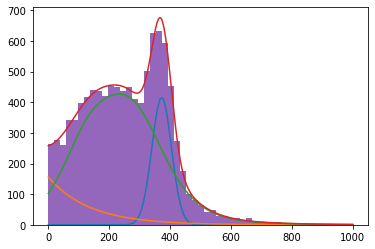

In [53]:
plot_comp_model(model_ext_sum, data)

# Fit result

The result of every minimization is stored in a `FitResult`. This is the last stage of the zfit workflow and serves as an interface to other libraries.

In [54]:
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.SumPDF  params=[Composed_autoparam_5, Composed_autoparam_6, Composed_autoparam_7] dtype=float64>0] data=[<zfit.core.data.SampleData object at 0x7f24d8484310>] constraints=[]> 
with
<Minuit strategy=PushbackStrategy tolerance=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00019 │ -1.942e+04  │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name               value    at limit
---------------  -------  ----------
sig_yield           1677       False
comb_bkg_yield      1060       False
part_reco_yield     7263       False
mu_sig             372.5       False
sigma_sig          32.28       False


To just see the parameters and values

In [55]:
print(result.params)

name               value    at limit
---------------  -------  ----------
sig_yield           1677       False
comb_bkg_yield      1060       False
part_reco_yield     7263       False
mu_sig             372.5       False
sigma_sig          32.28       False


It is a dictionary that can be accesed with the name of the parameter:

In [56]:
result.params[sigma_sig]

{'value': 32.27542339937658}

To obtain values from the minimization process, we access atributes of `result`.

In [57]:
result.fmin

-19422.30914778111

## Estimating uncertainties

`FitResult` ahs two methods to estimate uncertainty

- profile likelihood method
- Hessian approximation of the likelihood (the one we've been using)

Minuit has it's own method, but we can use the Hessian zfit implements.

In [59]:
result.hesse(method='minuit_hesse')

# Parameter name='hesse' is not valid in this version of zfit

OrderedDict([(<zfit.Parameter 'sig_yield' floating=True value=1677>,
              {'error': 71.28919431077672}),
             (<zfit.Parameter 'comb_bkg_yield' floating=True value=1060>,
              {'error': 85.22927565273427}),
             (<zfit.Parameter 'part_reco_yield' floating=True value=7263>,
              {'error': 141.39037707144186}),
             (<zfit.Parameter 'mu_sig' floating=True value=372.5>,
              {'error': 1.399195178461705}),
             (<zfit.Parameter 'sigma_sig' floating=True value=32.28>,
              {'error': 1.2869930909806304})])

In [60]:
print(result.params)

name               value    minuit_hesse    at limit
---------------  -------  --------------  ----------
sig_yield           1677     +/-      71       False
comb_bkg_yield      1060     +/-      85       False
part_reco_yield     7263     +/- 1.4e+02       False
mu_sig             372.5     +/-     1.4       False
sigma_sig          32.28     +/-     1.3       False


In [62]:
errors, new_result = result.errors(params=[sig_yield, part_reco_yield, mu_sig])  # just using three for speed reasons

# name='errors' is not a valid parameter in this version of zfit

/home/carlos/anaconda3/envs/ayudantia_38/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:358: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


return Minos error 0.0072075  , -0.00323778
return Minos error -0.00695766  , 0.0129026
return Minos error 0.00432971  , -0.00194543


In [63]:
print(errors)

OrderedDict([(<zfit.Parameter 'sig_yield' floating=True value=1677>, MError(name='sig_yield', is_valid=True, lower=-71.7986544457863, upper=71.05406402802556, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=54, min=1677.1975999327626)), (<zfit.Parameter 'part_reco_yield' floating=True value=7263>, MError(name='part_reco_yield', is_valid=True, lower=-140.3830999081056, upper=143.19068197764426, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=72, min=7262.75592603788)), (<zfit.Parameter 'mu_sig' floating=True value=372.5>, MError(name='mu_sig', is_valid=True, lower=-1.405245894759329, upper=1.3964657877653082, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lo

In [65]:
# The calculated errors are added automatically to the result params

print(result.params)

name               value    minuit_hesse         minuit_minos    at limit
---------------  -------  --------------  -------------------  ----------
sig_yield           1677     +/-      71  -     72   +     71       False
comb_bkg_yield      1060     +/-      85                            False
part_reco_yield     7263     +/- 1.4e+02  -1.4e+02   +1.4e+02       False
mu_sig             372.5     +/-     1.4  -    1.4   +    1.4       False
sigma_sig          32.28     +/-     1.3                            False
